# Data Structures for Search

In the previous reading, we introduced breadth-first search (BFS); when searching for a path between two nodes, BFS (in contrast to DFS) finds the shortest one, if one exists at all.

A key detail of the BFS strategy is a TODO list of work to be done (that is, nodes to be visited).  A loop keeps popping nodes from the front of the list (and visiting them), then adding new nodes discovered in the process to the end of the list.  The search is done when the list is empty, or a path is found.  Our prior use of lists for the TODO list was inneficient; in this reading, we'll think more broadly about TODO lists and how to use efficient alternatives to lists.

A data structure to which we only append to the end and from which we only remove items from the front is called a *queue*, or sometimes FIFO (First-In First-Out) queue.  There are three patterns with special names that are worth remembering:

**queue**
* add to the end
* remove from the front

**stack**
* add to the end
* remove from the end

**priority queue**
* add items anywhere
* remove smallest/largest

**Fun fact:** if the queue in the BFS algorithm were replaced with a stack, it wouldn't be BFS anymore; perhaps surprisingly, the resulting search algorithm would be a non-recursive DFS search.

It's often a bad idea, but Python lists case be used with all three patterns:

In [1]:
todo = ["E", "B", "A", "D", "C"]

# queue
todo.append("F")  # end
x = todo.pop(0)   # front

# stack
todo.append("G")  # end
x = todo.pop(-1)  # front

# priority queue
todo.append("H")  # end
todo.sort()
x = todo.pop(-1)  # smallest

Given your knowledge of what list operations are fast (constant time) and slow (for example, linear time or worse), which of the above patterns will be efficient?

Only the stack pattern is efficient, as making changes (pops/appends) at the end of a list is fast.  The queue pattern is slow: popping from the front is an O(N) operation.  The priority queue pattern is even worse: sorting is generally an O(N log N) operation.

We'll now discuss more efficient options for queues and priority queues.

## Queue Pattern and `deque`

The Python deque (double-edged queue) data structure is efficient when used as either a stack or a queue.  You can easily convert a list to a deque, and you can append to a deque as you would a list.  One minor difference: instead of `L.pop(0)`, we'll use `dq.popleft()`.

In [2]:
from collections import deque

todo = deque(["E", "B", "A", "D", "C"])

# queue
todo.append("F")   # end
x = todo.popleft() # front

todo

deque(['B', 'A', 'D', 'C', 'F'])

We can use the deque type instead of lists to make the TODO queue for our BFS implementation more efficient.  The following shows our BFS code from last reading, with just three changes (indicated in the comments) necessary to switch from using a list to using a deque:

* `# CHANGE 1: import it`
* `# CHANGE 2: deque instead of list`
* `# CHANGE 3: .popleft instead of .pop(0)`

In [3]:
from graphviz import Graph, Digraph

In [4]:
from collections import deque # CHANGE 1: import it

class mygraph:
    def __init__(self):
        self.nodes = {}
    
    def node(self, name):
        self.nodes[name] = Node(self, name)
    
    def edge(self, src, dst):
        for name in [src, dst]:
            if not name in self.nodes:
                self.node(name)
        self.nodes[src].children.append(self.nodes[dst])
        
    def _repr_svg_(self):
        g = Digraph()
        for n in self.nodes:
            g.node(n)
            for child in self.nodes[n].children:
                g.edge(n, child.name)
        return g._repr_image_xml_svg()
    
    def find(self, src, dst):
        self.visited = set()
        return self.nodes[src].find(dst)

class Node:
    def __init__(self, graph, name):
        self.graph = graph
        self.name = name
        self.children = []
        
    def __repr__(self):
        return "node %s" % self.name
        
    def find(self, dst):
        todo = deque([self]) # CHANGE 2: deque instead of list
        self.back = None
        self.graph.visited.add(self.name)

        # keep looping while there are unexplored nodes
        while len(todo) > 0:
            curr = todo.popleft() # CHANGE 3: .popleft instead of .pop(0)

            if curr.name == dst:
                return backtrace(self, curr)
            else:
                for child in curr.children:
                    if not child.name in self.graph.visited:
                        todo.append(child) # NON-CHANGE 4: append is the same
                        child.back = curr
                        self.graph.visited.add(child.name)

        return None
    
def backtrace(self, node):
    nodes = []
    while node != None:
        nodes.append(node)
        node = node.back
    return tuple(reversed(nodes))

In [5]:
g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g.edge("E", "Z")
g.edge("C", "Z")
g.edge("B", "A")
g.find("A", "Z")

(node A, node C, node Z)

Same result, but it will be faster for large graphs.

## Priority Queue Pattern and `heapq`

A* ("A-start") is an important AI search algorithm: https://en.wikipedia.org/wiki/A*_search_algorithm that we won't learn in CS 320 (take CS 540 if you're interested).

Instead of using a *queue* to decide the order in which to visit nodes, a *priority queue* is used.

To see why we would want this, let's look at a motivating case.  Consider this graph:

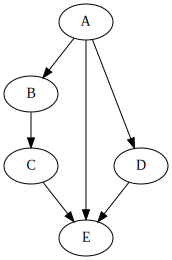

In [6]:
g = Digraph()
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "E")
g.edge("A", "D")
g.edge("D", "E")
g.edge("A", "E")
g

There are three paths from A to E:
1. A, B, C, E
2. A, E
3. A, D, E

Which path will DFS choose?  Which will BFS choose?

<details>
    <summary><b>ANSWER</b></summary>
      DFS will choose (1), BFS will choose (2)
</details>

Now what if we're trying to navitage between to points, and some roads/edges are longer than others:

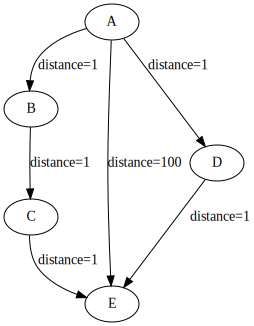

In [7]:
g = Digraph()
g.edge("A", "B", label="distance=1")
g.edge("B", "C", label="distance=1")
g.edge("C", "E", label="distance=1")
g.edge("A", "D", label="distance=1")
g.edge("D", "E", label="distance=1")
g.edge("A", "E", label="distance=100")
g

Which path do you prefer?  Unless you like the scenic route, presumably A,D,E -- the one than neither BFS or DFS chooses.

We need to base the order we explore nodes on distance.  Rather than popping from the front or end of `todo`, we want to pop closest first.  A priority queue is a structure that lets us do this.

Python's heapq functions can accomplish this: https://docs.python.org/3/library/heapq.html.  It doesn't need a special structure; it can cleverly arrange items in an underlying list to do this.

Let's try it:

In [8]:
from heapq import heappush, heappop

prioq = [] # regular list

heappush(prioq, 4)
heappush(prioq, 3)
heappush(prioq, 5)
heappush(prioq, 1)

print("QUEUE:", prioq)

print(heappop(prioq))
print(heappop(prioq))
print(heappop(prioq))

print("QUEUE:", prioq)
heappush(prioq, 2)
print("QUEUE:", prioq)

print(heappop(prioq))
print(heappop(prioq))

QUEUE: [1, 3, 5, 4]
1
3
4
QUEUE: [5]
QUEUE: [2, 5]
2
5


See how the smallest item remaining is always what you get with `heappop`?

You could logically accomplish the same by sorting the list each time before you want to do `.pop(0)`, but that would be WAY slower.

With the heapq implementation of priority queue, adding and removing items has O(log N) complexity (https://en.wikipedia.org/wiki/Binary_heap#Summary_of_running_times).  In contrast, sorting before each pop would have complexity O(N log N).  Ouch!

# Conclusion

There are many ways to techniques for searching through a graph for a value or a path that vary in terms of which nodes are explored first and the extra data structures needed to keep track of work to be done.  This simplest is probably recursive DFS (depth-first search); that one is also very memory efficient for graphs that branch out quickly but are not very deep.

Unfortunately, DFS isn't good at finding short paths.  BFS (breadth-first search) is guaranteed to find the shorter path.  On the other hand, it tends to be harder to implement, and the data structure used to keep track of work to be done can require a lot of memory.

We also learned about three patterns for keeping track of nodes to explore, and efficient data structures for each pattern:
* stack (can be used for non-recursive DFS) -- a regular Python list makes a good stack (deque is also a good option)
* queue (used for BFS) -- dequeue is efficient
* priority queue (used for A*, which we don't cover in CS 320) -- using heapq to add/remove items in a regular Python list is a good option